In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
import matplotlib.cm as cm
import warnings
warnings.filterwarnings(action = 'ignore')
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score,cross_validate,train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc,accuracy_score,precision_recall_curve
from sklearn import neighbors,preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
import sklearn.linear_model as LM
from sklearn.model_selection import GridSearchCV
import sklearn.neural_network as net
import scipy.stats as st
from scipy.optimize import root,fsolve
from sklearn.feature_selection import VarianceThreshold, SelectKBest,f_classif,chi2
from sklearn.feature_selection import RFE,RFECV,SelectFromModel
from sklearn.linear_model import Lasso, LassoCV, lasso_path,Ridge,RidgeCV
from sklearn.linear_model import enet_path,ElasticNetCV,ElasticNet
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from boruta import BorutaPy
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
import itertools

In [2]:
# Fetch Dataset
data=pd.read_excel('dataset5.xlsx')
X=data.iloc[:,1:86]
Y=data.iloc[:,86]

In [3]:
# Lasso Regression
model = LassoCV()
model.fit(X,Y)
print('The number of remaining variables after Lasso regression: %d'%sum(model.coef_==0))
print('The best alpha is: ',model.alpha_)
lassoAlpha=model.alpha_

estimator = Lasso(alpha=lassoAlpha) 
selector=SelectFromModel(estimator=estimator)
selector.fit(X,Y)
print("The threshold is: %s"%selector.threshold_)
print("Lasso Regression: The number of remaining variables is %d"%len(selector.get_support(indices=True)))

colIndex = list(selector.get_support(indices=True))
X_useFeature = X.iloc[:,colIndex]  # get selected features
print(X_useFeature.shape)

The number of remaining variables after Lasso regression: 61
The best alpha is:  0.0020137797634826008
The threshold is: 1e-05
Lasso Regression: The number of remaining variables is 24
(1628, 24)


In [4]:
# get unselected features
X_uselessFeature = X.drop(X.columns[colIndex], axis = 1, inplace = False)
print(X_uselessFeature.shape)

(1628, 61)


In [5]:
# Division of training set and testing set
# With selected features
X_train, X_test, Y_train, Y_test = train_test_split(X_useFeature,Y,train_size=0.70, random_state=123) 

# With unselected features
X_train_useless, X_test_useless, Y_train_useless, Y_test_useless = train_test_split(X_uselessFeature,Y,train_size=0.70, random_state=123)

# With all features
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X,Y,train_size=0.70, random_state=123) 

In [6]:
print(X_train.columns)

Index(['OD', 'Age', 'BMI', 'PF', 'HT', 'HL', 'SRK', 'WBCC', 'PON', 'CH', 'PLT',
       'POL', 'ALC', 'POM', 'ANC', 'MCV', 'MCH', 'RBCDC', 'MPV', 'PVDW', 'CS',
       'CCH', 'AP', 'CRP'],
      dtype='object')


In [7]:
# draw bar chart of feature importance
def drawImportance(modelname, feature_importances):
    # compute feature importance
    features_import = pd.DataFrame(X_train.columns, columns=['feature'])
    features_import['importance'] = feature_importances
    features_import.sort_values('importance', inplace=True)
    
    # draw bar chart
    plt.barh(features_import['feature'], features_import['importance'], height=0.5, color='#5CACEE', edgecolor='#5CACEE')
    plt.xlabel('feature importance', font={'family':'Arial', 'size':16})
    plt.ylabel('features', font={'family':'Arial', 'size':16})
    plt.title('{} Algorithm'.format(modelname), font={'family':'Arial', 'size':16})
    plt.savefig("{}.png".format(modelname),dpi=600)


# KNN

## Use Important Features

In [8]:
# Gaussian kernel function
def guass(x):
    x=preprocessing.scale(x)
    output=1/np.sqrt(2*np.pi)*np.exp(-x*x/2)
    return output

modelKNN=neighbors.KNeighborsClassifier(n_neighbors=10,weights=guass)
modelKNN.fit(X_train,Y_train)

Y_test_pre=modelKNN.predict(X_test)

In [9]:
# AUC
Y_test_prob = modelKNN.predict_proba(X_test)[:, 1]
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(Y_test, Y_test_prob)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)
print(roc_auc_KNN)

0.5784770654506437


[-0.00061425 -0.01056511 -0.00380835 -0.00061425 -0.00208845 -0.00036855
 -0.0002457  -0.0031941   0.02321867 -0.00454545  0.02960688 -0.00085995
 -0.00282555 -0.01388206 -0.00331695 -0.01007371  0.00380835 -0.0029484
 -0.00282555 -0.00847666 -0.01105651 -0.01167076  0.01277641  0.00896806]


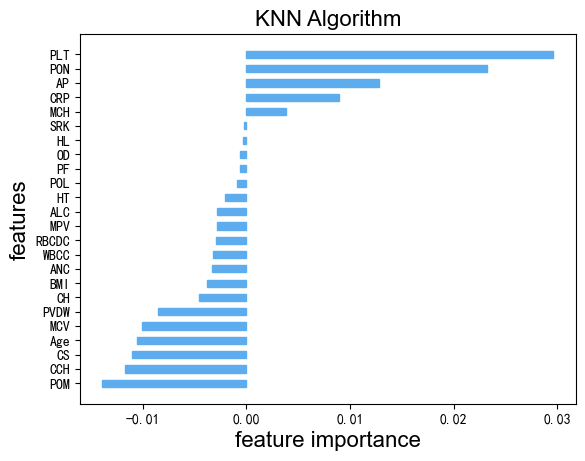

In [13]:
# perform permutation importance
results = permutation_importance(modelKNN, X_useFeature, Y, scoring = 'accuracy')
# get importance
importance = results.importances_mean
importanceKNN = importance
print(importanceKNN)
importance = importance

drawImportance('KNN', importance)

## Use Remaining Features

In [14]:
modelKNN1=neighbors.KNeighborsClassifier(n_neighbors=10,weights=guass)
modelKNN1.fit(X_train_useless,Y_train_useless)

Y_test_pre1=modelKNN1.predict(X_test_useless)

In [16]:
# AUC
Y_test_prob1 = modelKNN1.predict_proba(X_test_useless)[:, 1]
fpr_KNN1, tpr_KNN1, threshold_KNN1 = roc_curve(Y_test_useless,Y_test_prob1) 
roc_auc_KNN1 = auc(fpr_KNN1, tpr_KNN1) 
print(roc_auc_KNN1)

0.6152092274678111


## Use All Features

In [17]:
modelKNN2=neighbors.KNeighborsClassifier(n_neighbors=10,weights=guass)
modelKNN2.fit(X1_train,Y1_train)

Y_test_pre2=modelKNN2.predict(X1_test)

In [18]:
# AUC
Y_test_prob2 = modelKNN2.predict_proba(X1_test)[:, 1]
fpr_KNN2, tpr_KNN2, threshold_KNN2 = roc_curve(Y1_test,Y_test_prob2)
roc_auc_KNN2 = auc(fpr_KNN2, tpr_KNN2) 
print(roc_auc_KNN2)

0.5751408261802575


# RF

## Use Important Features

In [19]:
RF=ensemble.RandomForestClassifier(n_estimators=120,oob_score=True,random_state=123,
                                      bootstrap=True)
RF.fit(X_train,Y_train)    
pre_rf_test=RF.predict(X_test)

[0.33501229 0.00479115 0.00405405 0.00110565 0.12825553 0.
 0.00036855 0.0027027  0.00110565 0.0027027  0.0014742  0.0036855
 0.00184275 0.00405405 0.00503686 0.0017199  0.00135135 0.00257985
 0.0029484  0.00896806 0.00184275 0.0027027  0.00454545 0.01302211]


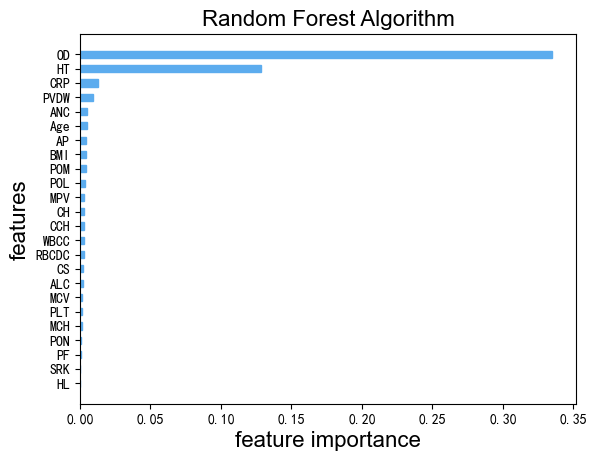

In [20]:
# perform permutation importance
results = permutation_importance(RF, X_useFeature, Y, scoring = 'accuracy')
# get importance
importance = results.importances_mean

importanceRF = importance
print(importanceRF)
drawImportance('Random Forest', importance)

In [21]:
# AUC
Y_test_prob = RF.predict_proba(X_test)[:, 1]
fpr_RF, tpr_RF, threshold_RF = roc_curve(Y_test,Y_test_prob)
roc_auc_RF = auc(fpr_RF, tpr_RF) 
print(roc_auc_RF)

0.9571486051502145


## Use Remaining Features

In [22]:
RF1=ensemble.RandomForestClassifier(n_estimators=120,oob_score=True,random_state=123,
                                      bootstrap=True)
RF1.fit(X_train_useless,Y_train_useless)    
pre_rf1_test=RF1.predict(X_test_useless)

In [23]:
# 剩余AUC
Y_test_prob1 = RF1.predict_proba(X_test_useless)[:, 1]
fpr_RF1, tpr_RF1, threshold_RF1 = roc_curve(Y_test_useless,Y_test_prob1)
roc_auc_RF1 = auc(fpr_RF1, tpr_RF1)
print(roc_auc_RF1)

0.5945798685622318


## Use All Features

In [24]:
RF2=ensemble.RandomForestClassifier(n_estimators=120,oob_score=True,random_state=123,
                                      bootstrap=True)
RF2.fit(X1_train,Y1_train)    
pre_rf2_test=RF2.predict(X1_test)

In [25]:
# AUC
Y_test_prob2 = RF2.predict_proba(X1_test)[:, 1]
fpr_RF2, tpr_RF2, threshold_RF2 = roc_curve(Y1_test,Y_test_prob2)
roc_auc_RF2 = auc(fpr_RF2, tpr_RF2)
print(roc_auc_RF2)

0.9500402360515021


# AdaBoost

## Use Important Features

In [26]:
# Build weak model
dt_stump = tree.DecisionTreeClassifier(max_depth=12, min_samples_leaf=1)
adaBoost = ensemble.AdaBoostClassifier(estimator=dt_stump,n_estimators=150,
                                      random_state=123)

adaBoost.fit(X_train,Y_train)
pre_adaBoost_test=adaBoost.predict(X_test)

[ 3.29852580e-01  8.59950860e-04  1.47420147e-03  1.47420147e-03
  3.09582310e-02 -2.45700246e-04  3.68550369e-04 -8.59950860e-04
  7.37100737e-04 -1.22850123e-03  4.91400491e-04 -8.59950860e-04
 -9.82800983e-04 -9.82800983e-04 -6.14250614e-04  6.14250614e-04
 -3.68550369e-04  1.59705160e-03  1.22850123e-04  8.59950860e-04
  1.10565111e-03 -4.91400491e-04  1.22850123e-03  5.03685504e-03]


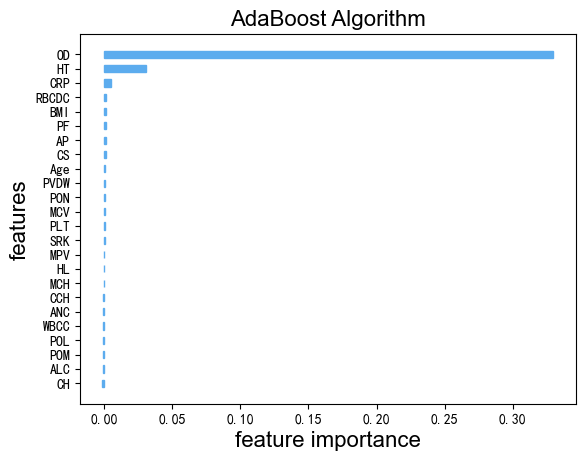

In [27]:
# perform permutation importance
results = permutation_importance(adaBoost, X_useFeature, Y, scoring = 'accuracy')
# get importance
importance = results.importances_mean

importanceAda = importance
print(importanceAda)
drawImportance('AdaBoost', importance)

In [28]:
# AUC
Y_test_prob = adaBoost.predict_proba(X_test)[:, 1]
fpr_Ada, tpr_Ada, threshold_Ada = roc_curve(Y_test,Y_test_prob)
roc_auc_Ada = auc(fpr_Ada, tpr_Ada)
print(roc_auc_Ada)

0.9564109442060086


## Use Remaining Features

In [29]:
dt_stump = tree.DecisionTreeClassifier(max_depth=12, min_samples_leaf=1)
adaBoost1 = ensemble.AdaBoostClassifier(estimator=dt_stump,n_estimators=150,
                                      random_state=123)

adaBoost1.fit(X_train_useless,Y_train_useless)
pre_adaBoost1_test=adaBoost1.predict(X_test_useless)

In [30]:
# 剩余AUC
Y_test_prob1 = adaBoost1.predict_proba(X_test_useless)[:, 1]
fpr_Ada1, tpr_Ada1, threshold_Ada1 = roc_curve(Y_test_useless,Y_test_prob1)
roc_auc_Ada1 = auc(fpr_Ada1, tpr_Ada1)
print(roc_auc_Ada1)

0.5818635997854077


## Use All Features

In [31]:
dt_stump = tree.DecisionTreeClassifier(max_depth=12, min_samples_leaf=1)
adaBoost2 = ensemble.AdaBoostClassifier(estimator=dt_stump,n_estimators=150,
                                      random_state=123)

adaBoost2.fit(X1_train,Y1_train)
pre_adaBoost2_test=adaBoost2.predict(X1_test)

In [32]:
# AUC
Y_test_prob2 = adaBoost2.predict_proba(X1_test)[:, 1]
fpr_Ada2, tpr_Ada2, threshold_Ada2 = roc_curve(Y1_test,Y_test_prob2)
roc_auc_Ada2 = auc(fpr_Ada2, tpr_Ada2) 
print(roc_auc_Ada2)

0.9502749463519313


# MLP

## Use Important Features

In [33]:
NeuNet=net.MLPClassifier(activation='logistic',random_state=123,hidden_layer_sizes=(60,),max_iter=2000)

NeuNet.fit(X_train,Y_train)
pre_net_test=NeuNet.predict(X_test)

[ 3.22604423e-01  4.05405405e-03 -1.47420147e-03  5.65110565e-03
  9.74201474e-02  4.91400491e-04  7.37100737e-04  8.59950860e-04
  6.87960688e-03  5.77395577e-03  1.09336609e-02  1.96560197e-03
 -8.59950860e-04  2.57985258e-03  5.52825553e-03  1.35135135e-03
  2.45700246e-03 -4.91400491e-04  9.82800983e-04 -8.59950860e-04
 -9.82800983e-04  2.45700246e-04  1.03194103e-02  1.20393120e-02]


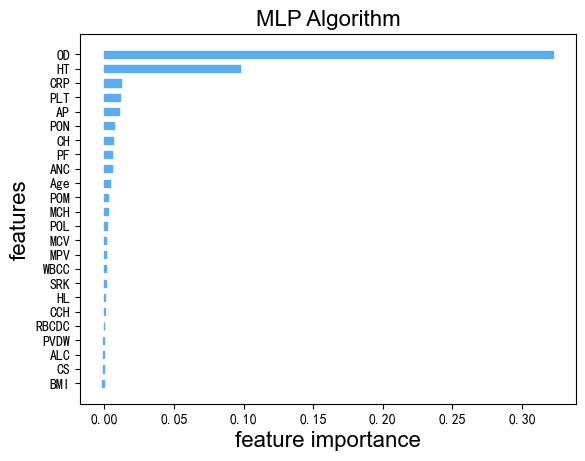

In [34]:
# perform permutation importance
results = permutation_importance(NeuNet, X_useFeature, Y, scoring = 'accuracy')
# get importance
importance = results.importances_mean

importanceMLP = importance
print(importanceMLP)
drawImportance('MLP', importance)

In [35]:
# AUC
Y_test_prob = NeuNet.predict_proba(X_test)[:, 1]
fpr_MLP, tpr_MLP, threshold_MLP = roc_curve(Y_test, Y_test_prob)
roc_auc_MLP = auc(fpr_MLP, tpr_MLP)
print(roc_auc_MLP)

0.9466872317596566


## Use Remaining Features

In [36]:
NeuNet1=net.MLPClassifier(activation='logistic',random_state=123,hidden_layer_sizes=(60,),max_iter=2000)

NeuNet1.fit(X_train_useless,Y_train_useless)
pre_net1_test=NeuNet1.predict(X_test_useless)

In [37]:
# AUC
Y_test_prob1 = NeuNet1.predict_proba(X_test_useless)[:, 1]
fpr_MLP1, tpr_MLP1, threshold_MLP1 = roc_curve(Y_test_useless, Y_test_prob1)
roc_auc_MLP1 = auc(fpr_MLP1, tpr_MLP1)
print(roc_auc_MLP1)

0.6126777092274678


## Use All Features

In [38]:
NeuNet2=net.MLPClassifier(activation='logistic',random_state=123,hidden_layer_sizes=(60,),max_iter=2000)

NeuNet2.fit(X1_train,Y1_train)
pre_net2_test=NeuNet2.predict(X1_test)

In [39]:
# AUC
Y_test_prob2 = NeuNet2.predict_proba(X1_test)[:, 1]
fpr_MLP2, tpr_MLP2, threshold_MLP2 = roc_curve(Y1_test, Y_test_prob2) 
roc_auc_MLP2 = auc(fpr_MLP2, tpr_MLP2) 
print(roc_auc_MLP2)

0.9333422746781116


# DT

## Use Important Features

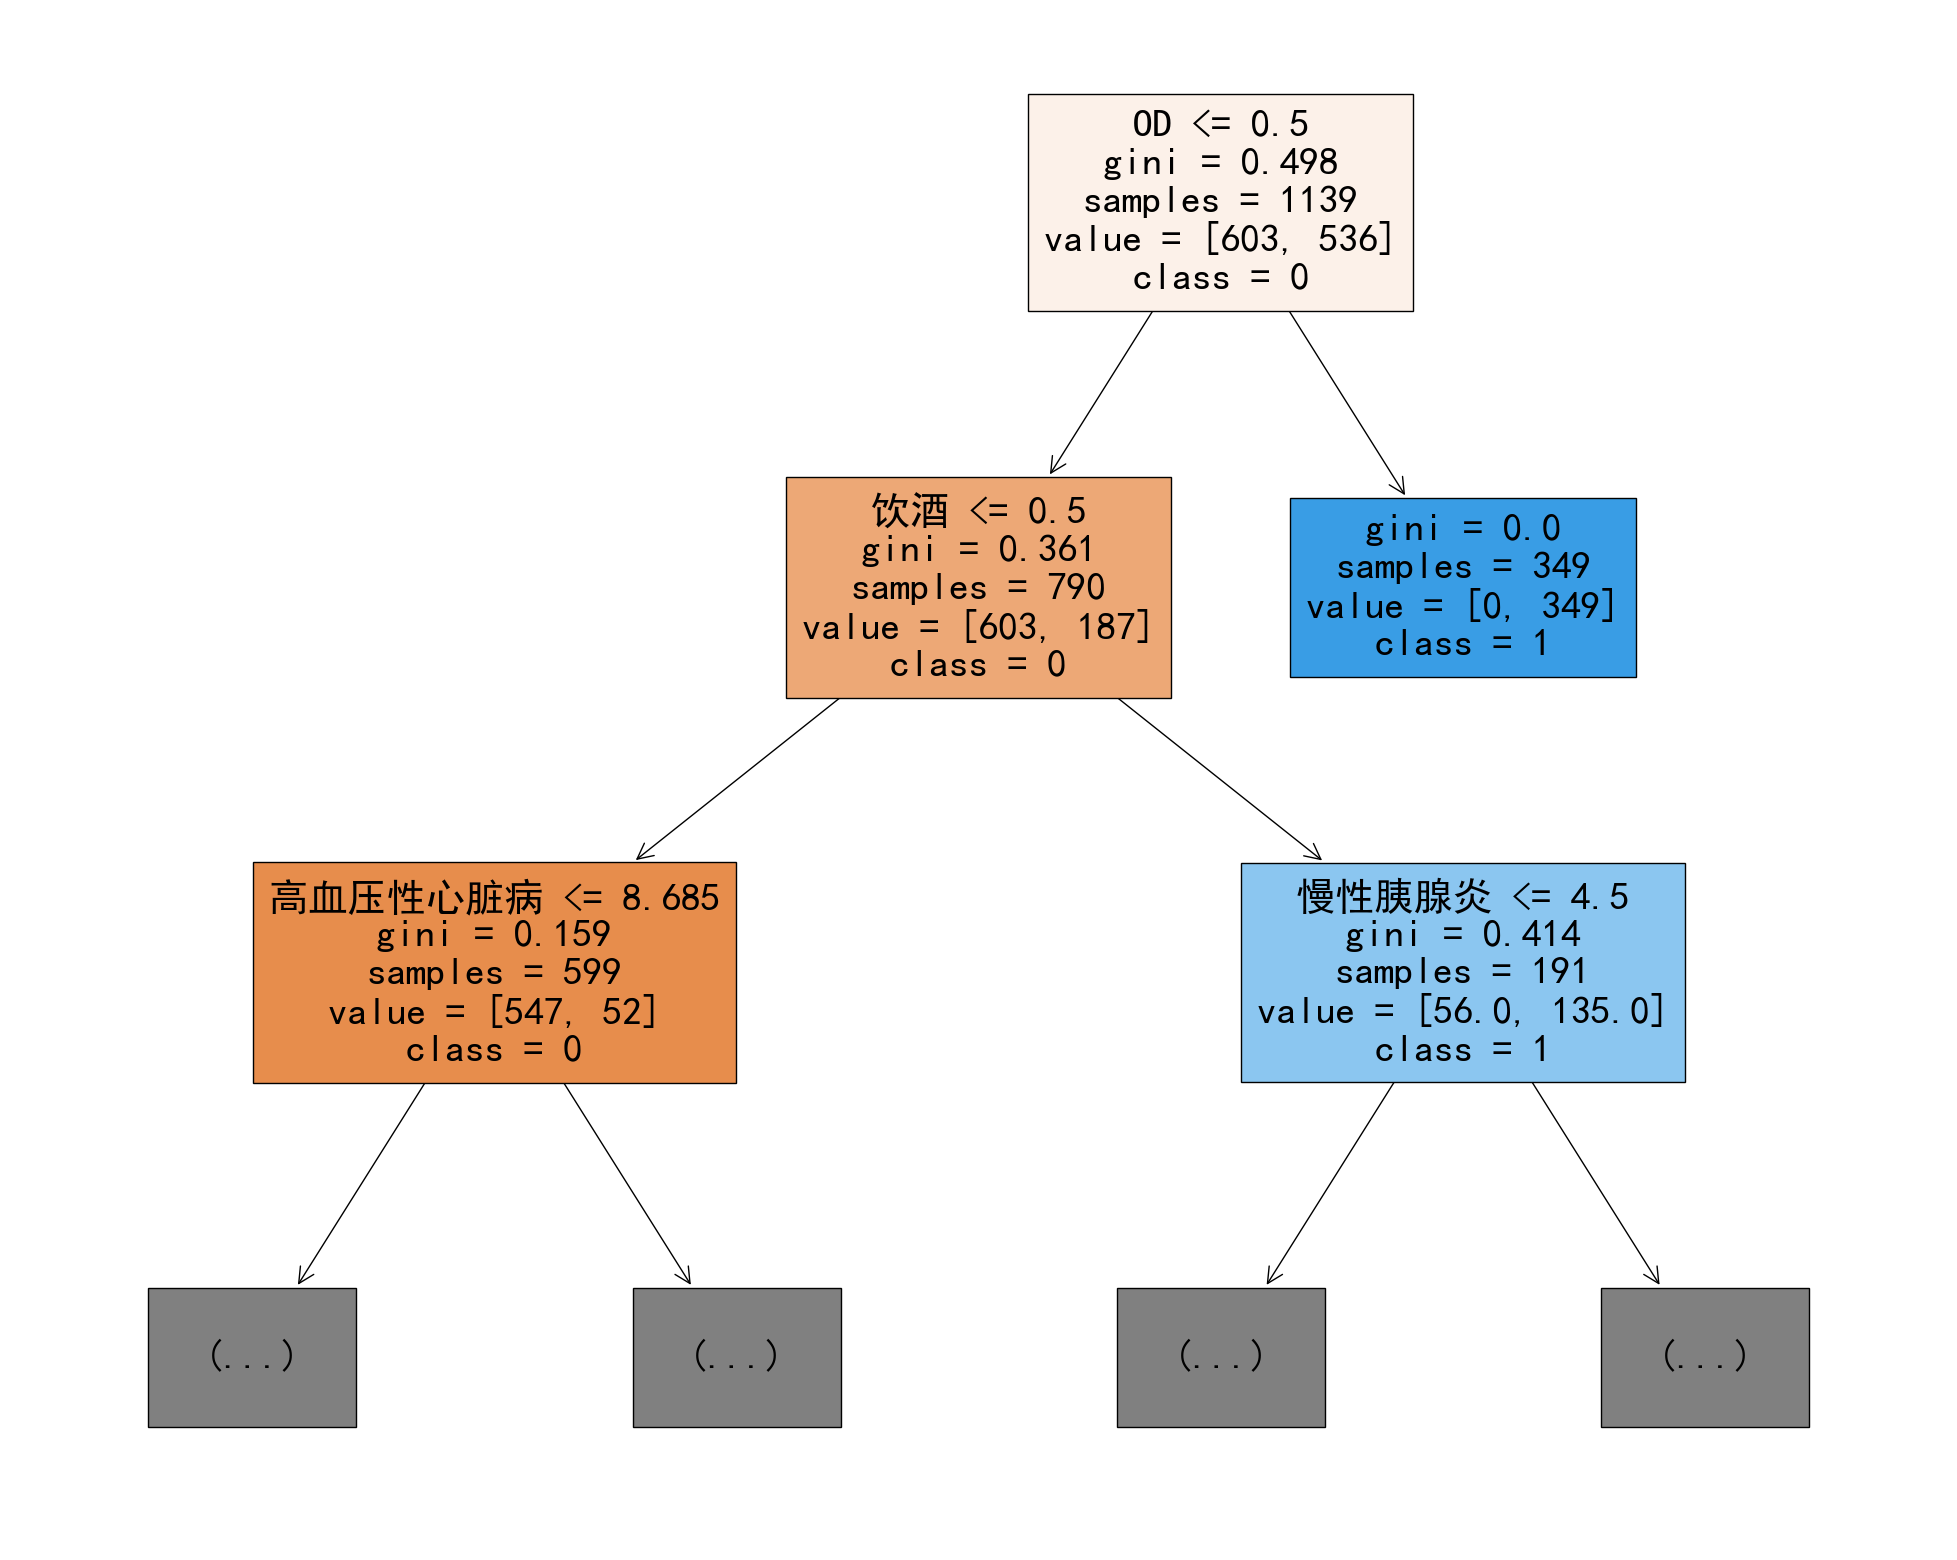

In [78]:
modelDTC = tree.DecisionTreeClassifier(max_depth=10,random_state=123)

modelDTC.fit(X_train, Y_train)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(
    modelDTC, 
    feature_names=X.columns,  
    class_names=['0','1'],
    filled=True,
    max_depth=2
)

# Save picture
fig.savefig("decistion_tree.png")

[ 3.33169533e-01  1.21621622e-02  6.75675676e-03  1.46191646e-02
  1.23955774e-01  0.00000000e+00  0.00000000e+00  2.48157248e-02
  6.01965602e-03 -4.44089210e-17  3.68550369e-04  1.84275184e-03
  5.15970516e-03  5.65110565e-03  1.62162162e-02  9.09090909e-03
  1.47420147e-02  3.31695332e-03  3.68550369e-03  2.39557740e-02
  1.96560197e-03  1.05651106e-02  1.17936118e-02  3.72235872e-02]


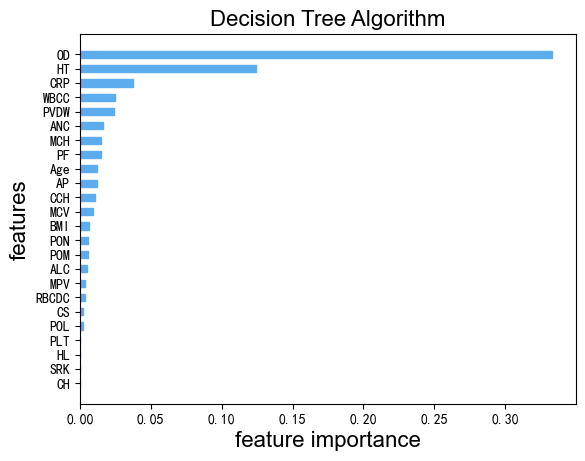

In [79]:
# perform permutation importance
results = permutation_importance(modelDTC, X_useFeature, Y, scoring = 'accuracy')
# get importance
importance = results.importances_mean

importanceDT = importance
print(importanceDT)
drawImportance('Decision Tree', importance)

In [80]:
# AUC
Y_test_prob = modelDTC.predict_proba(X_test)[:, 1]
fpr_DT, tpr_DT, threshold_DT = roc_curve(Y_test,Y_test_prob)
roc_auc_DT = auc(fpr_DT, tpr_DT)
print(fpr_DT)
print(roc_auc_DT)

[0.         0.109375   0.12890625 0.27734375 1.        ]
0.8798283261802575


## Use Remaining Features

In [47]:
modelDTC1 = tree.DecisionTreeClassifier(max_depth=10,random_state=123)

modelDTC1.fit(X_train_useless, Y_train_useless)

DecisionTreeClassifier(max_depth=10, random_state=123)

In [48]:
# AUC
Y_test_prob1 = modelDTC1.predict_proba(X_test_useless)[:, 1]
fpr_DT1, tpr_DT1, threshold_DT1 = roc_curve(Y_test_useless,Y_test_prob1)
roc_auc_DT1 = auc(fpr_DT1, tpr_DT1)
print(roc_auc_DT1)

0.5756186292918455


## Use All Features

In [49]:
modelDTC2 = tree.DecisionTreeClassifier(max_depth=10,random_state=123)
modelDTC2.fit(X1_train, Y1_train)

DecisionTreeClassifier(max_depth=10, random_state=123)

In [50]:
# AUC
Y_test_prob2 = modelDTC2.predict_proba(X1_test)[:, 1]
fpr_DT2, tpr_DT2, threshold_DT2 = roc_curve(Y1_test,Y_test_prob2)
roc_auc_DT2 = auc(fpr_DT2, tpr_DT2)
print(roc_auc_DT2)

0.8971298283261804


# XGBoost

## Use Important Features

In [51]:
XGBmodel = XGBClassifier(learning_rate=0.3,
                          n_estimators=150,        
                          max_depth=12)

XGBmodel.fit(X_train, Y_train)
pre_XGBoost_test=XGBmodel.predict(X_test)

[ 3.37592138e-01  4.42260442e-03  1.71990172e-03  6.38820639e-03
  1.42997543e-01  0.00000000e+00  0.00000000e+00 -6.14250614e-04
 -1.47420147e-03  1.35135135e-03 -1.22850123e-04  9.82800983e-04
  4.91400491e-04  3.68550369e-04  2.45700246e-04  3.07125307e-03
  1.10565111e-03  1.35135135e-03  2.57985258e-03  1.09336609e-02
 -2.45700246e-04  1.96560197e-03  2.33415233e-03  2.33415233e-02]


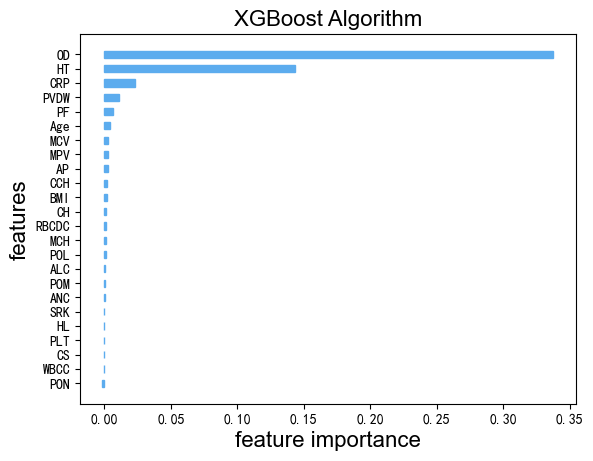

In [52]:
# perform permutation importance
results = permutation_importance(XGBmodel, X_useFeature, Y, scoring = 'accuracy')
# get importance
importance = results.importances_mean

importanceXG = importance
print(importanceXG)
drawImportance('XGBoost', importance)

In [53]:
# AUC
Y_test_prob = XGBmodel.predict_proba(X_test)[:, 1]
fpr_XG, tpr_XG, threshold_XG = roc_curve(Y_test,Y_test_prob) 
roc_auc_XG = auc(fpr_XG, tpr_XG)
print(roc_auc_XG)

0.9531920600858369


## Use Remaining Features

In [57]:
# 使用非重要特征
XGBmodel1 = XGBClassifier(learning_rate=0.3,
                          n_estimators=150,  
                          max_depth=12)

XGBmodel1.fit(X_train_useless, Y_train_useless)
pre_XGBoost1_test=XGBmodel1.predict(X_test_useless)

In [58]:
# AUC
Y_test_prob1 = XGBmodel1.predict_proba(X_test_useless)[:, 1]
fpr_XG1, tpr_XG1, threshold_XG1 = roc_curve(Y_test_useless,Y_test_prob1) 
roc_auc_XG1 = auc(fpr_XG1, tpr_XG1) 
print(roc_auc_XG1)

0.5410407725321889


## Use All Features

In [56]:
XGBmodel2 = XGBClassifier(learning_rate=0.3,
                          n_estimators=150,  
                          max_depth=12)

XGBmodel2.fit(X1_train, Y1_train)

pre_XGBoost2_test=XGBmodel2.predict(X1_test)

In [59]:
# AUC
Y_test_prob2 = XGBmodel2.predict_proba(X1_test)[:, 1]
fpr_XG2, tpr_XG2, threshold_XG2 = roc_curve(Y1_test,Y_test_prob2) 
roc_auc_XG2 = auc(fpr_XG2, tpr_XG2) 
print(roc_auc_XG2)

0.9530914699570816


# SVM

## Use Important Features

In [60]:
parameters = {'C':[1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
              'gamma':[0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]}


modelSVC=svm.SVC(kernel='rbf', probability = True)
clf = GridSearchCV(modelSVC, parameters, cv=5, n_jobs=8)
clf.fit(X_train,Y_train)

pre_svm_test=clf.predict(X_test)

[ 0.06031941  0.02567568  0.00085995 -0.00085995  0.00565111  0.00012285
 -0.0002457  -0.00429975  0.09299754  0.02113022  0.07972973  0.09066339
 -0.00110565  0.0034398  -0.00380835  0.0044226   0.01977887  0.01105651
  0.00405405  0.00663391 -0.0007371   0.00282555  0.06130221  0.03058968]


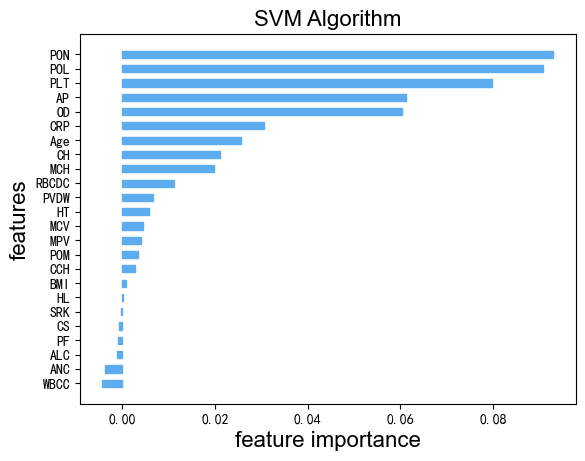

In [61]:
# perform permutation importance
results = permutation_importance(clf, X_useFeature, Y, scoring = 'accuracy')
# get importance
importance = results.importances_mean

importanceSVM = importance
print(importanceSVM)
drawImportance('SVM', importance)

In [62]:
# AUC
Y_test_prob = clf.predict_proba(X_test)[:, 1]
fpr_SVM, tpr_SVM, threshold_SVM = roc_curve(Y_test, Y_test_prob)
roc_auc_SVM = auc(fpr_SVM, tpr_SVM) 
print(roc_auc_SVM)

0.7282557671673819


## Use Remaining Features

In [63]:
clf = GridSearchCV(modelSVC, parameters, cv=5, n_jobs=8)
clf.fit(X_train_useless,Y_train_useless)
pre_svm1_test=clf.predict(X_test_useless)

In [64]:
# AUC
Y_test_prob1 = clf.predict_proba(X_test_useless)[:, 1]
fpr_SVM1, tpr_SVM1, threshold_SVM1 = roc_curve(Y_test_useless, Y_test_prob1)
roc_auc_SVM1 = auc(fpr_SVM1, tpr_SVM1)
print(roc_auc_SVM1)

0.6031132644849786


## Use All Features

In [65]:
clf = GridSearchCV(modelSVC, parameters, cv=5, n_jobs=8)
clf.fit(X1_train,Y1_train)
pre_svm2_test=clf.predict(X1_test)

In [67]:
# AUC
Y_test_prob2 = clf.predict_proba(X1_test)[:, 1]
fpr_SVM2, tpr_SVM2, threshold_SVM2 = roc_curve(Y1_test, Y_test_prob2) 
roc_auc_SVM2 = auc(fpr_SVM2, tpr_SVM2)
print(roc_auc_SVM2)

0.7377950643776824


# NB

## Use Important Features

In [68]:
modelNB = GaussianNB()
modelNB.fit(X_train, Y_train)

GaussianNB()

In [69]:
# AUC
Y_test_prob = modelNB.predict_proba(X_test)[:, 1]
fpr_NB, tpr_NB, threshold_NB = roc_curve(Y_test,Y_test_prob) 
roc_auc_NB = auc(fpr_NB, tpr_NB) 
print(roc_auc_NB)

0.9383717811158799


[ 3.27641278e-01  9.82800983e-04  1.22850123e-04  7.37100737e-04
  1.70761671e-02  3.68550369e-04  2.57985258e-03  4.91400491e-03
  7.37100737e-04  6.14250614e-04  1.22850123e-03  1.71990172e-03
  2.45700246e-04  1.59705160e-03  4.42260442e-03  1.47420147e-03
  6.14250614e-04  1.10565111e-03  1.71990172e-03  6.14250614e-04
  8.59950860e-04  1.35135135e-03 -6.14250614e-04  1.84275184e-03]


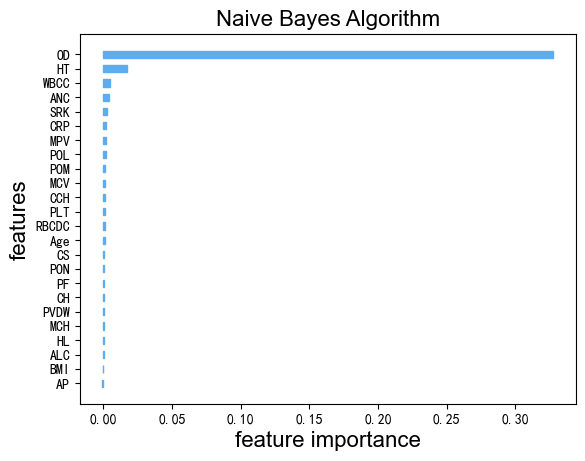

In [70]:
# perform permutation importance
results = permutation_importance(modelNB, X_useFeature, Y, scoring = 'accuracy')
# get importance
importance = results.importances_mean

importanceNB = importance
print(importanceNB)
# print(importance)

drawImportance('Naive Bayes', importance)

## Use Remaining Feautures

In [74]:
modelNB1 = GaussianNB()
modelNB1.fit(X_train_useless, Y_train_useless)

GaussianNB()

In [75]:
# AUC
Y_test_prob1 = modelNB1.predict_proba(X_test_useless)[:, 1]
fpr_NB1, tpr_NB1, threshold_NB1 = roc_curve(Y_test_useless,Y_test_prob1)
roc_auc_NB1 = auc(fpr_NB1, tpr_NB1)
print(roc_auc_NB1)

0.6086624865879828


## Use All Features

In [73]:
modelNB2 = GaussianNB()
modelNB2.fit(X1_train, Y1_train)

GaussianNB()

In [76]:
# AUC
Y_test_prob2 = modelNB2.predict_proba(X1_test)[:, 1]
fpr_NB2, tpr_NB2, threshold_NB2 = roc_curve(Y1_test,Y_test_prob2)
roc_auc_NB2 = auc(fpr_NB2, tpr_NB2)  ###计算auc的值
print(roc_auc_NB2)

0.884438707081545


# Draw AUC Curve of Important Features

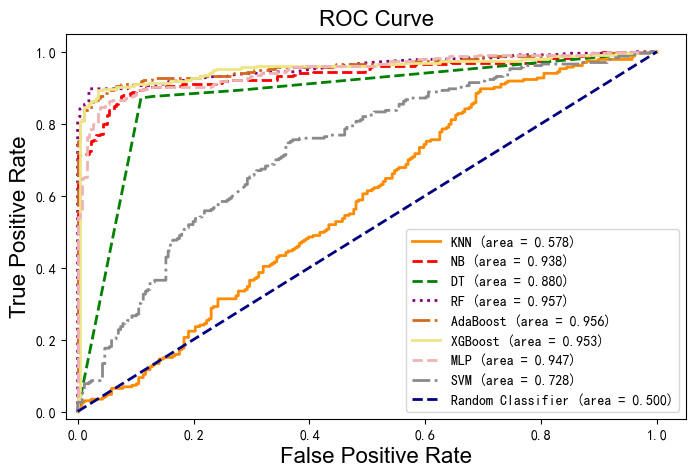

In [81]:
plt.figure(figsize=(8, 5))
plt.plot(fpr_KNN, tpr_KNN, color='darkorange', 
         lw=2, label='KNN (area = %0.3f)' % roc_auc_KNN, linestyle='-')
plt.plot(fpr_NB, tpr_NB, color='red',
         lw=2, label='NB (area = %0.3f)' % roc_auc_NB, linestyle='--')
plt.plot(fpr_DT, tpr_DT, color='green',
         lw=2, label='DT (area = %0.3f)' % roc_auc_DT, linestyle='--')
plt.plot(fpr_RF, tpr_RF, color='#800080',
         lw=2, label='RF (area = %0.3f)' % roc_auc_RF, linestyle=':')
plt.plot(fpr_Ada, tpr_Ada, color='#D2691E',
         lw=2, label='AdaBoost (area = %0.3f)' % roc_auc_Ada, linestyle='-.')
plt.plot(fpr_XG, tpr_XG, color='#EEE685',
         lw=2, label='XGBoost (area = %0.3f)' % roc_auc_XG, linestyle='-')
plt.plot(fpr_MLP, tpr_MLP, color='#EEB4B4',
         lw=2, label='MLP (area = %0.3f)' % roc_auc_MLP, linestyle='--')
plt.plot(fpr_SVM, tpr_SVM, color='#8B8989',
         lw=2, label='SVM (area = %0.3f)' % roc_auc_SVM, linestyle='-.')
plt.plot([0, 1], [0, 1], color='navy', lw=2,label='Random Classifier (area = 0.500)', linestyle='--')
plt.xlim([-0.02, 1.05])
plt.ylim([-0.02, 1.05])
plt.xlabel('False Positive Rate', font={'family':'Arial', 'size':16})
plt.ylabel('True Positive Rate', font={'family':'Arial', 'size':16})
plt.title('ROC Curve', font={'family':'Arial', 'size':16})
plt.legend(loc="lower right")
plt.savefig("hyh_IM.png",dpi=600)
plt.show()

# Draw AUC Curve of All Features

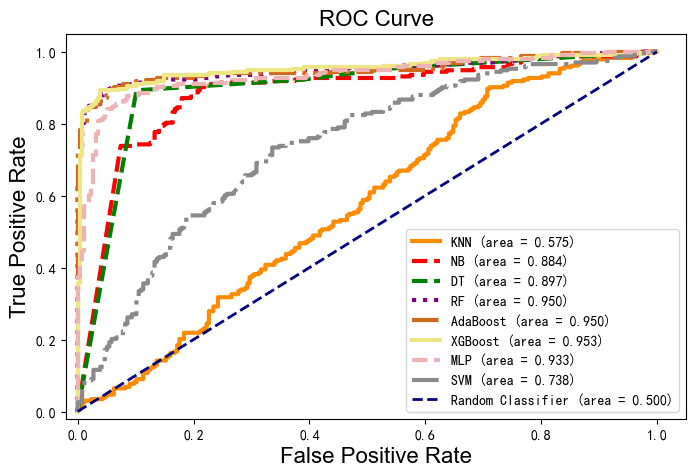

In [82]:
plt.figure(figsize=(8, 5))
plt.plot(fpr_KNN2, tpr_KNN2, color='darkorange', ###假正率为横坐标，真正率为纵坐标做曲线
         lw=3, label='KNN (area = %0.3f)' % roc_auc_KNN2, linestyle='-') #linestyle为线条的风格（共五种）,color为线条颜色
plt.plot(fpr_NB2, tpr_NB2, color='red',
         lw=3, label='NB (area = %0.3f)' % roc_auc_NB2, linestyle='--')
plt.plot(fpr_DT2, tpr_DT2, color='green',
         lw=3, label='DT (area = %0.3f)' % roc_auc_DT2, linestyle='--')
plt.plot(fpr_RF2, tpr_RF2, color='#800080',
         lw=3, label='RF (area = %0.3f)' % roc_auc_RF2, linestyle=':')
plt.plot(fpr_Ada2, tpr_Ada2, color='#D2691E',
         lw=3, label='AdaBoost (area = %0.3f)' % roc_auc_Ada2, linestyle='-.')
plt.plot(fpr_XG2, tpr_XG2, color='#EEE685',
         lw=3, label='XGBoost (area = %0.3f)' % roc_auc_XG2, linestyle='-')
plt.plot(fpr_MLP2, tpr_MLP2, color='#EEB4B4',
         lw=3, label='MLP (area = %0.3f)' % roc_auc_MLP2, linestyle='--')
plt.plot(fpr_SVM2, tpr_SVM2, color='#8B8989',
         lw=3, label='SVM (area = %0.3f)' % roc_auc_SVM2, linestyle='-.')
plt.plot([0, 1], [0, 1], color='navy', lw=2,label='Random Classifier (area = 0.500)', linestyle='--')
plt.xlim([-0.02, 1.05])#横竖增加一点长度 以便更好观察图像
plt.ylim([-0.02, 1.05])
plt.xlabel('False Positive Rate', font={'family':'Arial', 'size':16})
plt.ylabel('True Positive Rate', font={'family':'Arial', 'size':16})
plt.title('ROC Curve', font={'family':'Arial', 'size':16})
plt.legend(loc="lower right")
plt.savefig("hyh_AF.png",dpi=600)#保存图片，dpi设置分辨率
plt.show()

# Draw AUC Curve of Remaining Features

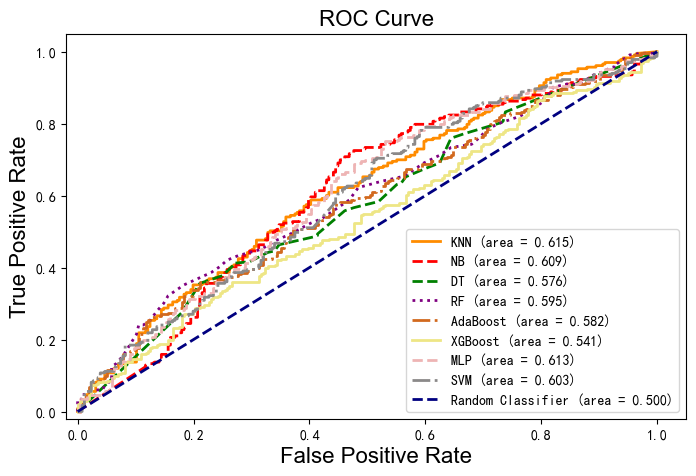

In [83]:
plt.figure(figsize=(8, 5))
plt.plot(fpr_KNN1, tpr_KNN1, color='darkorange', ###假正率为横坐标，真正率为纵坐标做曲线
         lw=2, label='KNN (area = %0.3f)' % roc_auc_KNN1, linestyle='-') #linestyle为线条的风格（共五种）,color为线条颜色
plt.plot(fpr_NB1, tpr_NB1, color='red',
         lw=2, label='NB (area = %0.3f)' % roc_auc_NB1, linestyle='--')
plt.plot(fpr_DT1, tpr_DT1, color='green',
         lw=2, label='DT (area = %0.3f)' % roc_auc_DT1, linestyle='--')
plt.plot(fpr_RF1, tpr_RF1, color='#800080',
         lw=2, label='RF (area = %0.3f)' % roc_auc_RF1, linestyle=':')
plt.plot(fpr_Ada1, tpr_Ada1, color='#D2691E',
         lw=2, label='AdaBoost (area = %0.3f)' % roc_auc_Ada1, linestyle='-.')
plt.plot(fpr_XG1, tpr_XG1, color='#EEE685',
         lw=2, label='XGBoost (area = %0.3f)' % roc_auc_XG1, linestyle='-')
plt.plot(fpr_MLP1, tpr_MLP1, color='#EEB4B4',
         lw=2, label='MLP (area = %0.3f)' % roc_auc_MLP1, linestyle='--')
plt.plot(fpr_SVM1, tpr_SVM1, color='#8B8989',
         lw=2, label='SVM (area = %0.3f)' % roc_auc_SVM1, linestyle='-.')
plt.plot([0, 1], [0, 1], color='navy', lw=2,label='Random Classifier (area = 0.500)', linestyle='--')
plt.xlim([-0.02, 1.05])#横竖增加一点长度 以便更好观察图像
plt.ylim([-0.02, 1.05])
plt.xlabel('False Positive Rate', font={'family':'Arial', 'size':16})
plt.ylabel('True Positive Rate', font={'family':'Arial', 'size':16})
plt.title('ROC Curve', font={'family':'Arial', 'size':16})
plt.legend(loc="lower right")
plt.savefig("hyh_RF.png",dpi=600)#保存图片，dpi设置分辨率
plt.show()

# Feature Importance Ranking

In [84]:
feature_importance = importanceKNN + importanceNB + importanceDT +importanceRF + importanceAda + importanceXG + importanceSVM + importanceMLP
print(feature_importance)

features_import = pd.DataFrame(X_train.columns, columns=['feature'])
features_import['importance'] = feature_importance
features_import.sort_values('importance', inplace=True)
print(features_import)

[ 2.04557740e+00  4.23832924e-02  9.70515971e-03  2.85012285e-02
  5.44226044e-01  3.68550369e-04  3.56265356e-03  2.43243243e-02
  1.30221130e-01  2.57985258e-02  1.23710074e-01  9.91400491e-02
  1.96560197e-03  2.82555283e-03  2.37100737e-02  1.16707617e-02
  4.34889435e-02  1.75675676e-02  1.32678133e-02  4.26289926e-02
 -7.24815725e-03  7.49385749e-03  1.03685504e-01  1.32063882e-01]
   feature  importance
20      CS   -0.007248
5       HL    0.000369
12     ALC    0.001966
13     POM    0.002826
6      SRK    0.003563
21     CCH    0.007494
2      BMI    0.009705
15     MCV    0.011671
18     MPV    0.013268
17   RBCDC    0.017568
14     ANC    0.023710
7     WBCC    0.024324
9       CH    0.025799
3       PF    0.028501
1      Age    0.042383
19    PVDW    0.042629
16     MCH    0.043489
11     POL    0.099140
22      AP    0.103686
10     PLT    0.123710
8      PON    0.130221
23     CRP    0.132064
4       HT    0.544226
0       OD    2.045577
